In [1]:
pip install numpy pandas scikit-learn xgboost lightgbm > null

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# Load and Prepare the Data

In [7]:
# Import data
df = pd.read_csv('data.csv')

# Calculate Change Percentage
df['Change_Percentage'] = df['Close'].pct_change() * 100

# Rename the column
df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Drop NaN values that result from the pct_change calculation
df.dropna(inplace=True)

# Define features and target variable
features = df.drop(['Close', 'Change_Percentage'], axis=1)
target = df['Change_Percentage']

df.head()

Date  Open  High   Low  Close  Adj Close    Volume  Close_Lag1  \
2311 2017-08-29  9.02  9.08  9.00   9.07   8.224794   73500.0        9.07   
2312 2017-08-30  9.08  9.11  9.05   9.11   8.261068   73500.0        9.07   
2313 2017-08-31  9.11  9.13  9.05   9.13   8.279206  443400.0        9.11   
2314 2017-09-01  9.13  9.18  9.12   9.16   8.306409  571800.0        9.13   
2315 2017-09-05  9.15  9.18  9.05   9.06   8.215731   73900.0        9.16   

      Open_Lag1  High_Lag1  ...  close_ED_constituent  close_ENPH_constituent  \
2311       9.06       9.07  ...             84.419998                    0.92   
2312       9.02       9.08  ...             84.080002                    0.95   
2313       9.08       9.11  ...             84.269997                    0.92   
2314       9.11       9.13  ...             83.989998                    0.98   
2315       9.13       9.18  ...             84.370003                    1.09   

      close_FSLR_constituent  close_ORSTED_constituent  close_VWS_constituent  \
2311               48.400002                329.700012             111.400002   
2312               48.090000                329.000000             112.300003   
2313               46.959999                325.200012             113.800003   
2314               47.840000                324.399994             115.000000   
2315               47.860001                326.000000             115.099998   

      close_^IBEX_constituent  close_XLI_etf  close_XLK_etf  close_XLU_etf  \
2311             10192.599609      67.949997      58.060001      55.119999   
2312             10245.799805      68.230003      58.480000      54.959999   
2313             10299.500000      68.459999      58.830002      54.970001   
2314             10325.500000      68.519997      58.779999      54.799999   
2315             10179.799805      67.830002      58.259998      54.939999   

      Change_Percentage  
2311           0.000000  
2312           0.441014  
2313           0.219539  
2314           0.328587  
2315          -1.091703  

[5 rows x 31 columns]

# Train-Test Split

In [8]:
# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)

# Scale the features
scaler = StandardScaler()

# Select only the numeric features for scaling
features_numeric = df.select_dtypes(include=[np.number])

# Scale the numeric features
features_scaled = scaler.fit_transform(features_numeric)

# Optionally, convert the scaled features back to a DataFrame for easier handling
scaled_df = pd.DataFrame(features_scaled, columns=features_numeric.columns, index=features.index)

# Insert the 'Date' column as the first column
scaled_df.insert(0, 'Date', features['Date'])

scaled_df


Date      Open      High       Low     Close  Adj Close    Volume  \
2311 2017-08-29 -1.151302 -1.150029 -1.144893 -1.142144  -1.200808 -0.856819   
2312 2017-08-30 -1.140805 -1.144848 -1.135983 -1.135132  -1.194383 -0.856819   
2313 2017-08-31 -1.135556 -1.141394 -1.135983 -1.131627  -1.191171 -0.746961   
2314 2017-09-01 -1.132057 -1.132758 -1.123510 -1.126368  -1.186353 -0.708827   
2315 2017-09-05 -1.128558 -1.132758 -1.135983 -1.143897  -1.202413 -0.856700   
...         ...       ...       ...       ...       ...        ...       ...   
4030 2024-07-01 -0.385023 -0.388393 -0.380474 -0.398920  -0.300166  0.238908   
4031 2024-07-02 -0.409516 -0.400483 -0.400075 -0.407684  -0.309022 -0.238657   
4032 2024-07-03 -0.392021 -0.362488 -0.371565 -0.349839  -0.250575  0.603497   
4033 2024-07-05 -0.357031 -0.346944 -0.337710 -0.346333  -0.247033 -0.100555   
4034 2024-07-08 -0.353532 -0.346944 -0.334146 -0.330557  -0.231093  0.380305   

      Close_Lag1  Open_Lag1  High_Lag1  ...  close_ED_constituent  \
2311   -1.142066  -1.143946  -1.151726  ...              0.008539   
2312   -1.142066  -1.150942  -1.149999  ...             -0.033360   
2313   -1.135054  -1.140448  -1.144818  ...             -0.009946   
2314   -1.131548  -1.135201  -1.141364  ...             -0.044452   
2315   -1.126289  -1.131703  -1.132729  ...              0.002378   
...          ...        ...        ...  ...                   ...   
4030   -0.397061  -0.339413  -0.350376  ...              0.549532   
4031   -0.398814  -0.384886  -0.388372  ...              0.569249   
4032   -0.407579  -0.409372  -0.400461  ...              0.537208   
4033   -0.349732  -0.391882  -0.362466  ...              0.606219   
4034   -0.346226  -0.356903  -0.346922  ...              0.501471   

      close_ENPH_constituent  close_FSLR_constituent  \
2311               -1.162645               -0.910790   
2312               -1.162311               -0.916605   
2313               -1.162645               -0.937805   
2314               -1.161976               -0.921296   
2315               -1.160750               -0.920920   
...                      ...                     ...   
4030               -0.088417                2.359391   
4031               -0.105031                2.247201   
4032               -0.067120                2.516980   
4033               -0.089755                2.348321   
4034               -0.026532                2.442125   

      close_ORSTED_constituent  close_VWS_constituent  \
2311                 -1.331604              -0.890036   
2312                 -1.334673              -0.873819   
2313                 -1.351333              -0.846790   
2314                 -1.354841              -0.825167   
2315                 -1.347826              -0.823366   
...                        ...                    ...   
4030                 -1.128609               0.023535   
4031                 -1.149654              -0.009801   
4032                 -1.095288               0.036148   
4033                 -1.025577               0.055969   
4034                 -1.077312               0.031644   

      close_^IBEX_constituent  close_XLI_etf  close_XLK_etf  close_XLU_etf  \
2311                 1.209935      -1.328376      -1.415136      -1.080917   
2312                 1.263209      -1.310850      -1.405666      -1.105123   
2313                 1.316984      -1.296454      -1.397775      -1.103610   
2314                 1.343020      -1.292699      -1.398902      -1.129328   
2315                 1.197118      -1.335886      -1.410627      -1.108149   
...                       ...            ...            ...            ...   
4030                 2.075534       1.964517       2.415247       0.817707   
4031                 1.931134       2.005827       2.440952       0.870656   
4032                 2.075333       2.033367       2.510624       0.932683   
4033                 2.041987       2.005827       2.526633       0.950838   
4034 

# Model Training and Evaluation

In [5]:
# Store results for comparison
results = {}

## ML models

Linear Regression


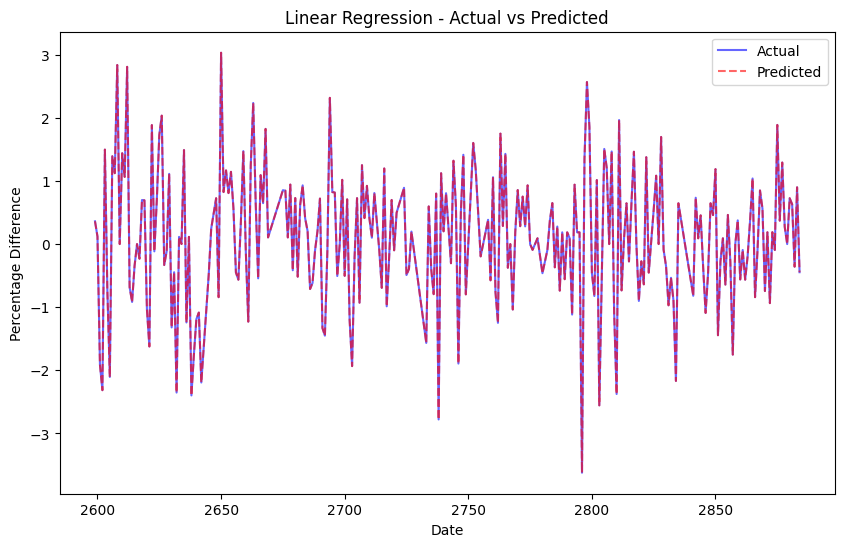

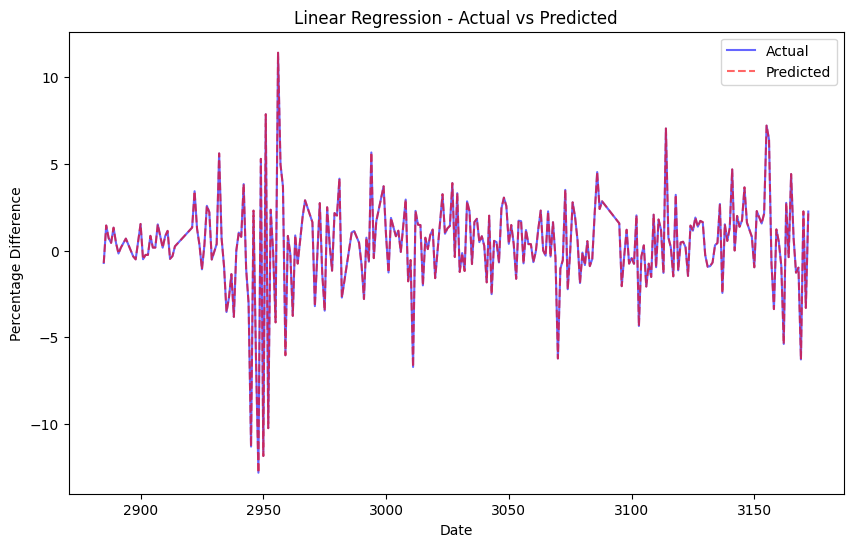

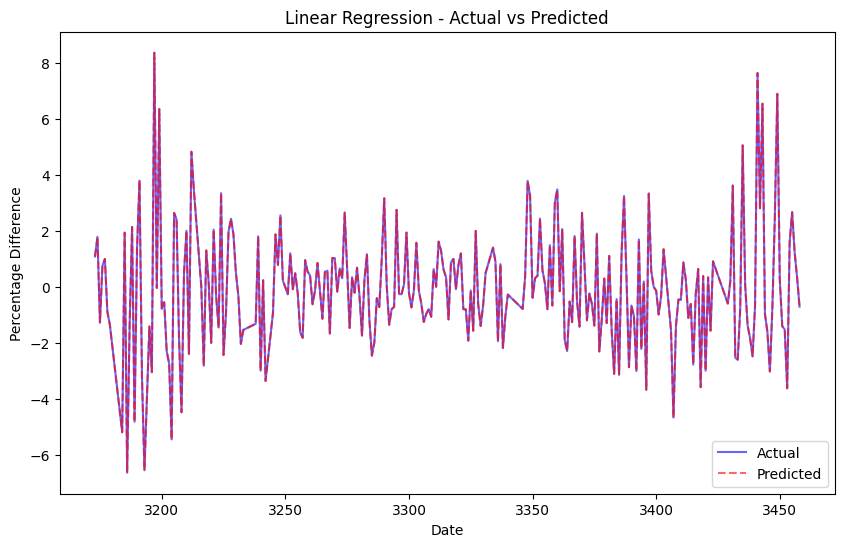

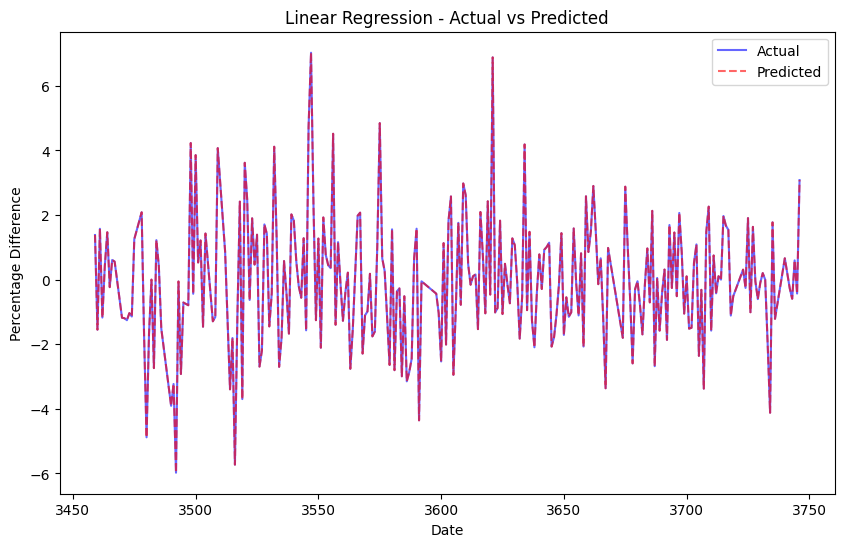

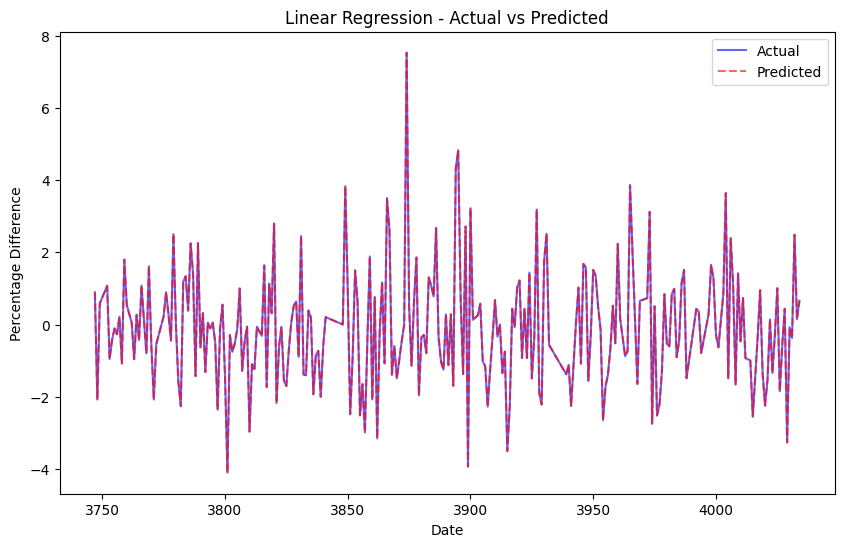

In [13]:
# Linear Regression Model
lr_model = LinearRegression()

# Store results for comparison
results = {}

# Perform Time Series Cross-Validation
for train_index, test_index in tscv.split(features_scaled):
    X_train, X_test = features_scaled[train_index], features_scaled[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_test)

    # Calculate Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results['Linear Regression'] = (mae, mse, r2)
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label='Actual', color='b', alpha=0.6)
    plt.plot(y_test.index, y_pred, label='Predicted', color='r', alpha=0.6, linestyle='--')
    plt.title('Linear Regression - Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Percentage Difference')
    plt.legend()
    plt.show()


Random Forest Regressor

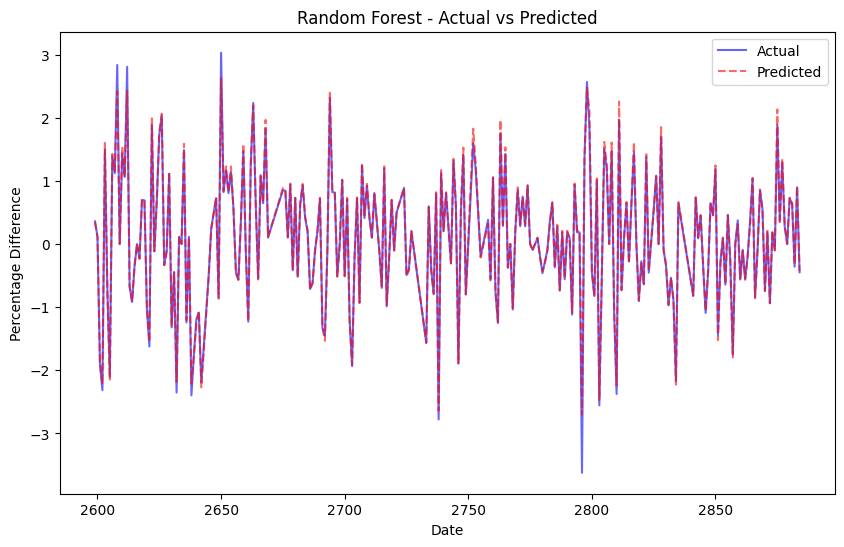

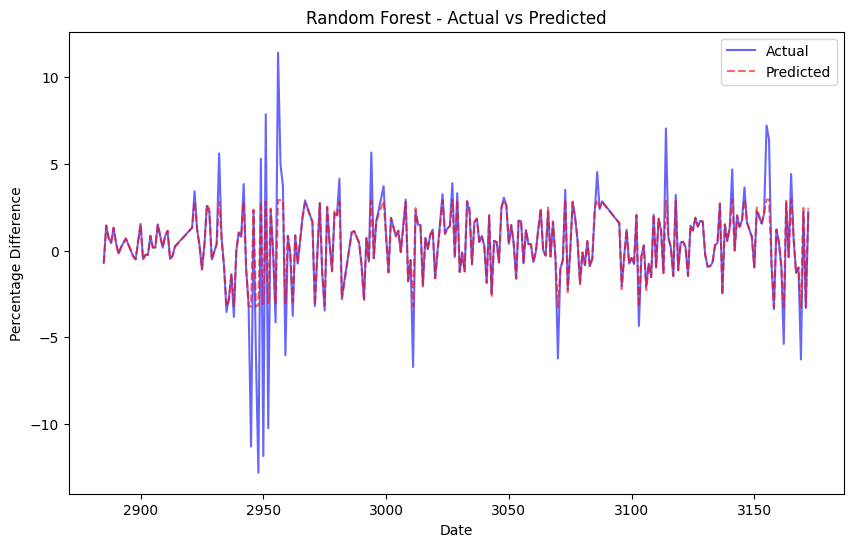

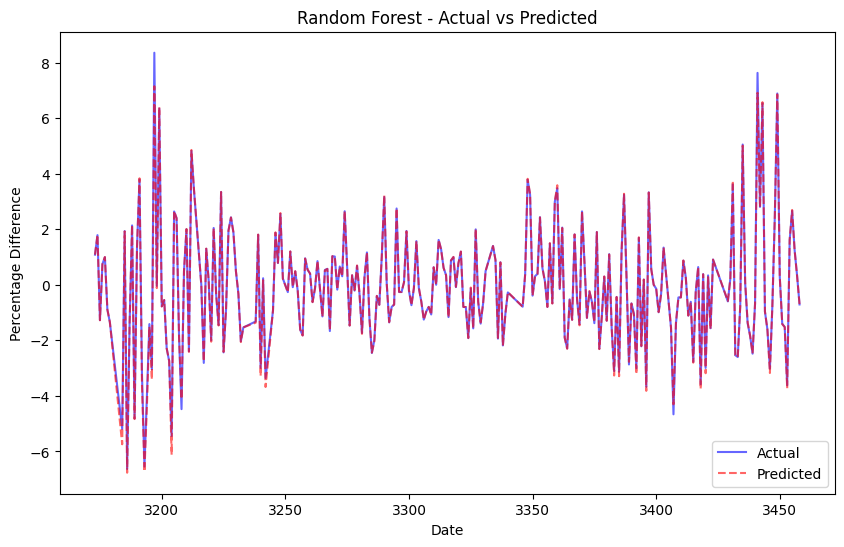

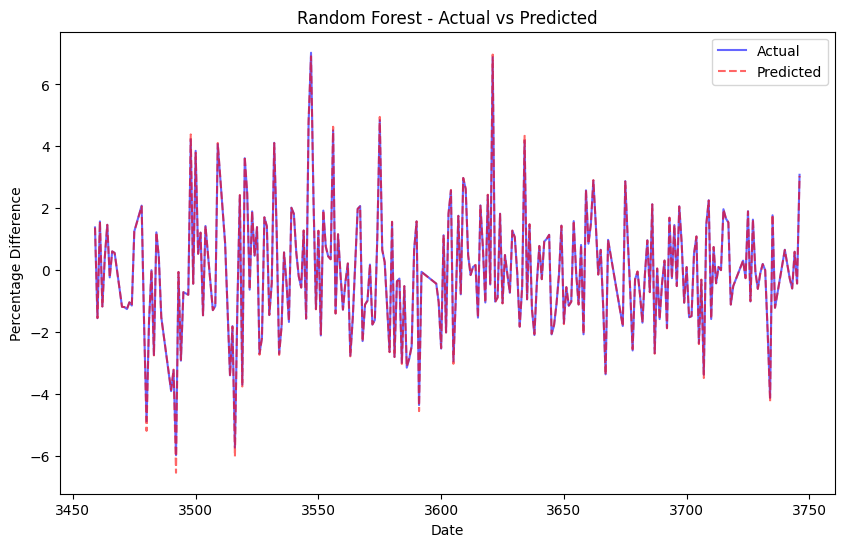

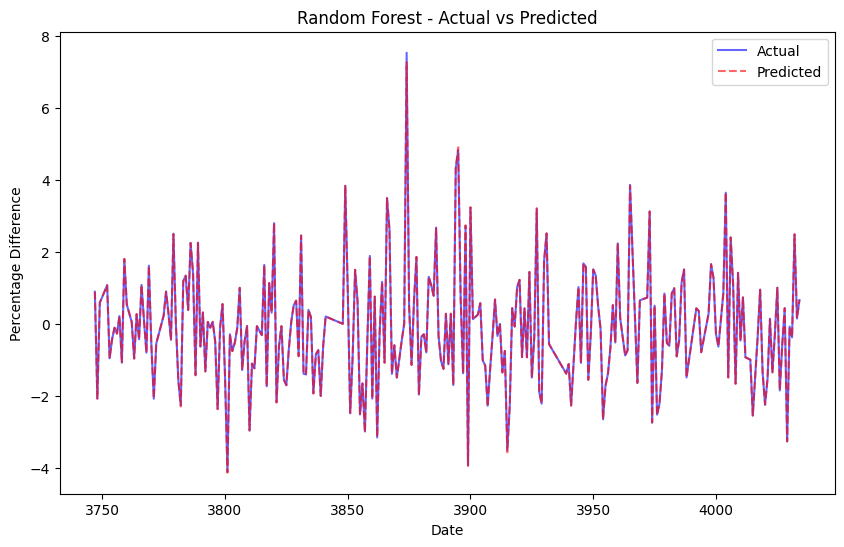

In [14]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform Time Series Cross-Validation
for train_index, test_index in tscv.split(features_scaled):
    X_train, X_test = features_scaled[train_index], features_scaled[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    # Calculate Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results['Random Forest'] = (mae, mse, r2)
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label='Actual', color='b', alpha=0.6)
    plt.plot(y_test.index, y_pred, label='Predicted', color='r', alpha=0.6, linestyle='--')
    plt.title('Random Forest - Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Percentage Difference')
    plt.legend()
    plt.show()


XGBoost Regressor

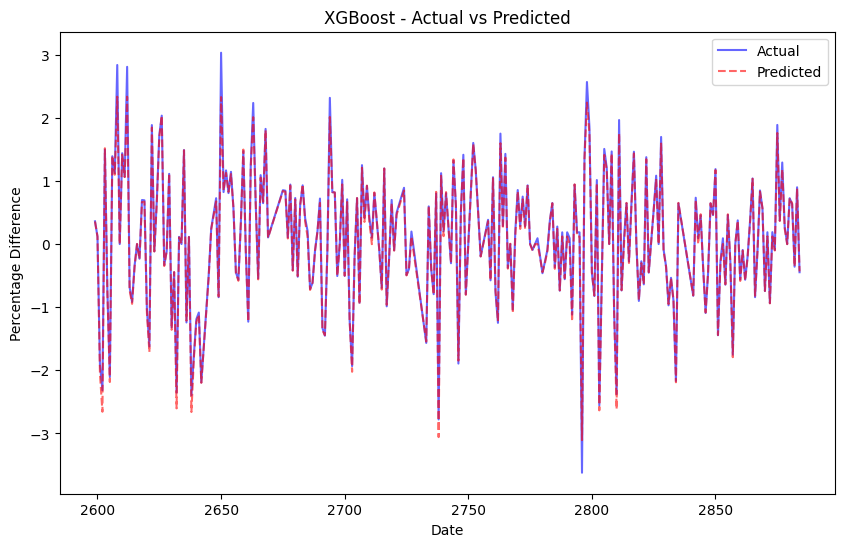

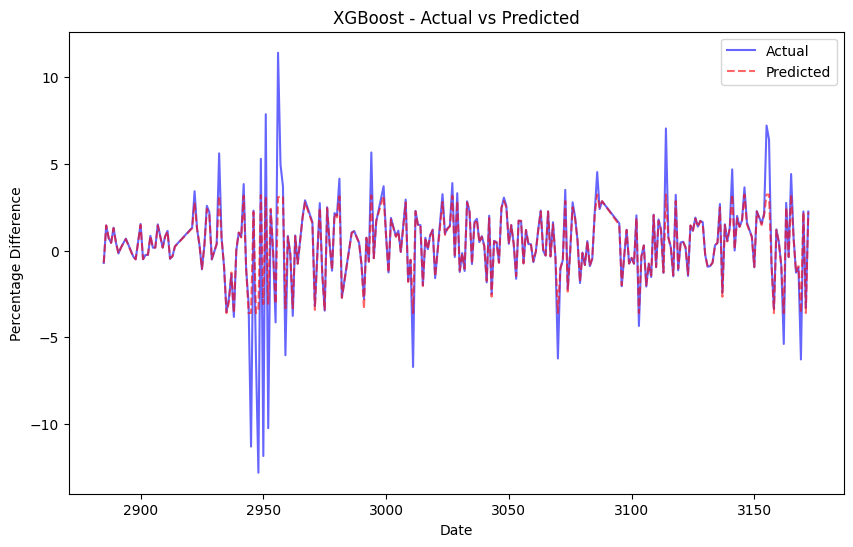

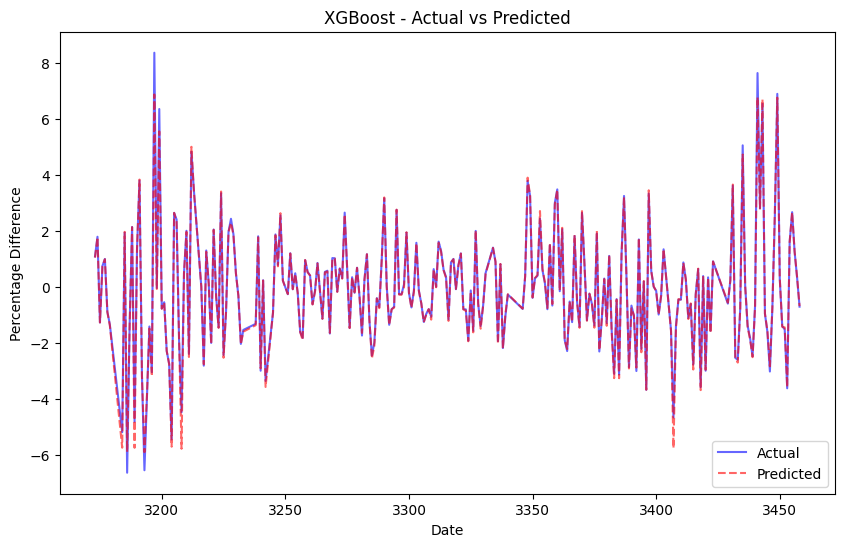

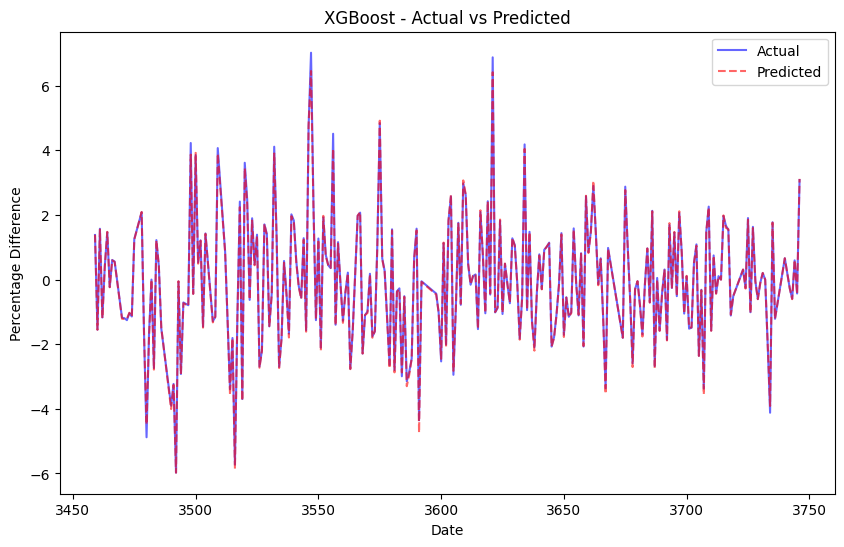

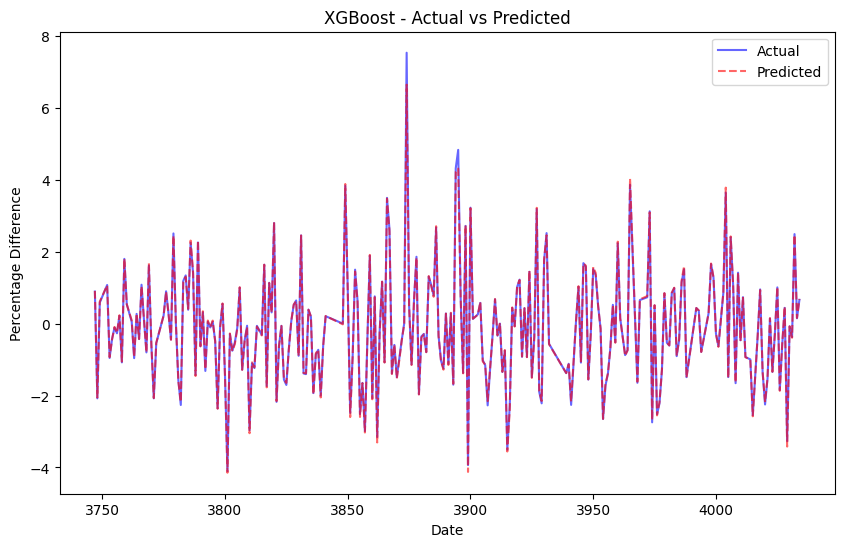

In [15]:
# XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Perform Time Series Cross-Validation
for train_index, test_index in tscv.split(features_scaled):
    X_train, X_test = features_scaled[train_index], features_scaled[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    # Calculate Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results['XGBoost'] = (mae, mse, r2)
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label='Actual', color='b', alpha=0.6)
    plt.plot(y_test.index, y_pred, label='Predicted', color='r', alpha=0.6, linestyle='--')
    plt.title('XGBoost - Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Percentage Difference')
    plt.legend()
    plt.show()


Compare Model Performance

In [9]:
print("Model Comparison Results:")
for model, metrics in results.items():
    print(f"{model}: MAE={metrics[0]:.4f}, MSE={metrics[1]:.4f}, R^2={metrics[2]:.4f}")


Model Comparison Results:
Linear Regression: MAE=0.0000, MSE=0.0000, R^2=1.0000
Random Forest: MAE=0.0060, MSE=0.0004, R^2=0.9999
XGBoost: MAE=0.0300, MSE=0.0055, R^2=0.9978


## Deep Learning Models

In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, Attention, Input
from tensorflow.keras.models import Model

# Assume features_scaled_df is already prepared with Date as the first column and scaled features
features = scaled_df.drop(columns=['Date'])
target = df['Change_Percentage']  # Assuming df contains the original Change_Percentage

# Convert to numpy arrays for TensorFlow compatibility
X = features.values
y = target.values

# Split data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


Feedforward Neural Network (FNN)

c:\Users\yogev\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


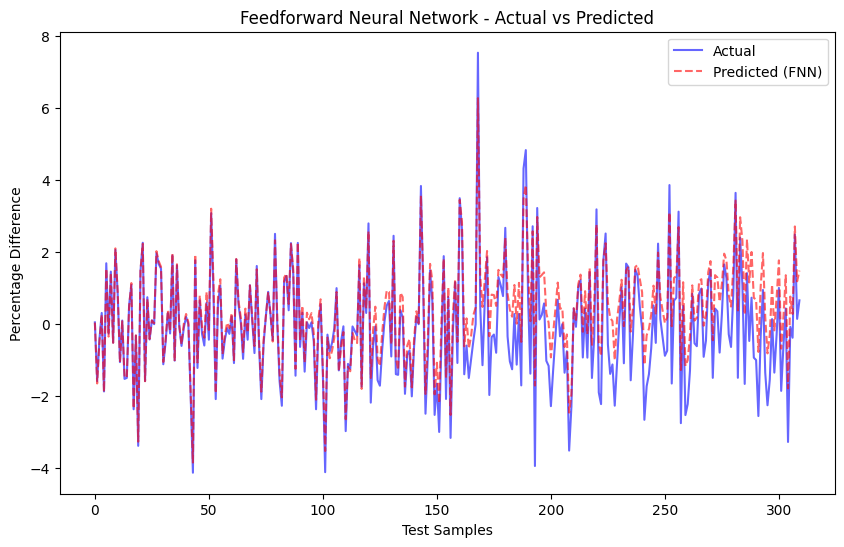

In [36]:
# Define Feedforward Neural Network model
fnn_model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile the model
fnn_model.compile(optimizer='adam', loss='mse')

# Train the model
fnn_history = fnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict on the test set
y_pred_fnn = fnn_model.predict(X_test)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='b', alpha=0.6)
plt.plot(y_pred_fnn, label='Predicted (FNN)', color='r', alpha=0.6, linestyle='--')
plt.title('Feedforward Neural Network - Actual vs Predicted')
plt.xlabel('Test Samples')
plt.ylabel('Percentage Difference')
plt.legend()
plt.show()


Long Short-Term Memory (LSTM) Network

In [18]:
# Reshape data for LSTM (assuming we use a window size of 5 timesteps)
window_size = 5

def create_lstm_data(X, y, window_size):
    X_lstm, y_lstm = [], []
    for i in range(len(X) - window_size):
        X_lstm.append(X[i:i+window_size])
        y_lstm.append(y[i+window_size])
    return np.array(X_lstm), np.array(y_lstm)

X_lstm_train, y_lstm_train = create_lstm_data(X_train, y_train, window_size)
X_lstm_test, y_lstm_test = create_lstm_data(X_test, y_test, window_size)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


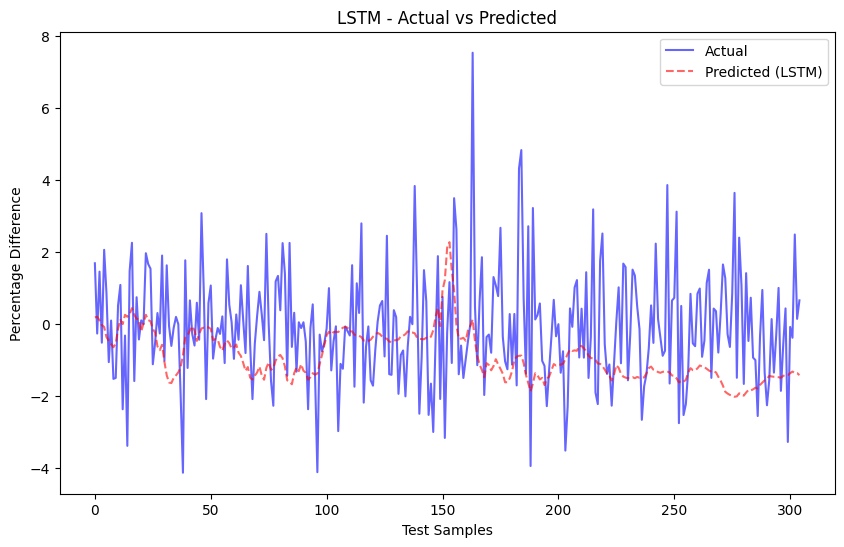

In [73]:
# Define LSTM model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_lstm_train.shape[1], X_lstm_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_history = lstm_model.fit(X_lstm_train, y_lstm_train, epochs=100, batch_size=32, validation_data=(X_lstm_test, y_lstm_test), verbose=0)

# Predict on the test set
y_pred_lstm = lstm_model.predict(X_lstm_test)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_lstm_test, label='Actual', color='b', alpha=0.6)
plt.plot(y_pred_lstm, label='Predicted (LSTM)', color='r', alpha=0.6, linestyle='--')
plt.title('LSTM - Actual vs Predicted')
plt.xlabel('Test Samples')
plt.ylabel('Percentage Difference')
plt.legend()
plt.show()


In [75]:
y_pred_lstm.shape

(305, 1)

Bidirectional LSTM model


Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 49: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 59: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 69: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 79: ReduceLROnPlateau reducing learning rate to 1e-05.
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


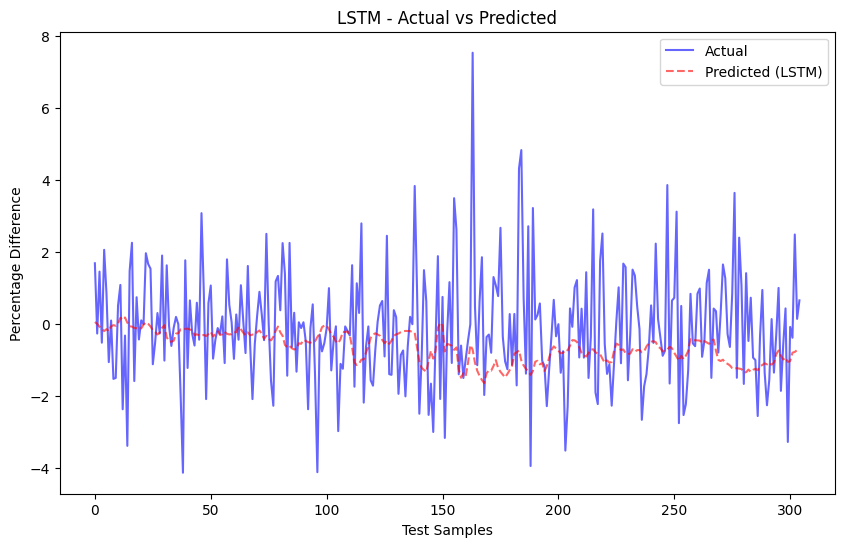

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define a more complex LSTM model
lstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(X_lstm_train.shape[1], X_lstm_train.shape[2]))),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=1, factor=0.5, min_lr=1e-5)

# Train the model
lstm_history = lstm_model.fit(X_lstm_train, y_lstm_train, epochs=100, batch_size=32, 
                              validation_data=(X_lstm_test, y_lstm_test), 
                              verbose=0, callbacks=[lr_scheduler])

# Predict on the test set
y_pred_lstm = lstm_model.predict(X_lstm_test)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_lstm_test, label='Actual', color='b', alpha=0.6)
plt.plot(y_pred_lstm, label='Predicted (LSTM)', color='r', alpha=0.6, linestyle='--')
plt.title('LSTM - Actual vs Predicted')
plt.xlabel('Test Samples')
plt.ylabel('Percentage Difference')
plt.legend()
plt.show()


Transformer Model

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 4.2785 - val_loss: 3.8670
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.0892 - val_loss: 3.3125
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 2.5049 - val_loss: 2.8881
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 2.5111 - val_loss: 2.5121
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 2.2471 - val_loss: 2.1884
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 1.9717 - val_loss: 1.9166
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 2.0914 - val_loss: 1.6963
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 2.0248 - val_loss: 1.4947
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 1.7477 - val_loss: 1.3385
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 1.6049 - val_loss: 1.2163
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 1.4926 - val_loss: 1.1094
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step

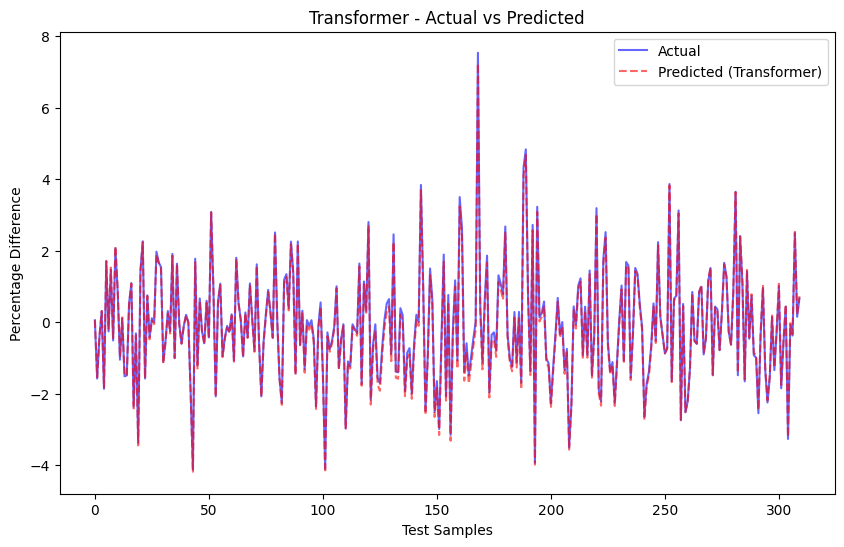

In [79]:
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Flatten
from tensorflow.keras.models import Model

# Custom Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = Dense(ff_dim, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

# Input
input_shape = (X_train.shape[1], 1)
inputs = Input(shape=input_shape)

# Transformer Block
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = transformer_encoder(x, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)

# Use Flatten to convert the 2D output to 1D
x = Flatten()(x)

# Output Layer
outputs = Dense(1)(x)  # Single output

# Model
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Predict on test data
y_pred_transformer = model.predict(X_test)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='b', alpha=0.6)
plt.plot(y_pred_transformer, label='Predicted (Transformer)', color='r', alpha=0.6, linestyle='--')
plt.title('Transformer - Actual vs Predicted')
plt.xlabel('Test Samples')
plt.ylabel('Percentage Difference')
plt.legend()
plt.show()


Temporal Convolutional Network (TCN)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.7571 - val_loss: 2.1335
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9804 - val_loss: 1.8743
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0835 - val_loss: 1.5765
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8983 - val_loss: 1.3095
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6095 - val_loss: 1.0032
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2670 - val_loss: 0.8423
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8554 - val_loss: 1.1367
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6189 - val_loss: 1.0576
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3782 - val_loss: 1.2431
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2322 - val_loss: 1.4450
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1780 - val_loss: 1.3490
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1

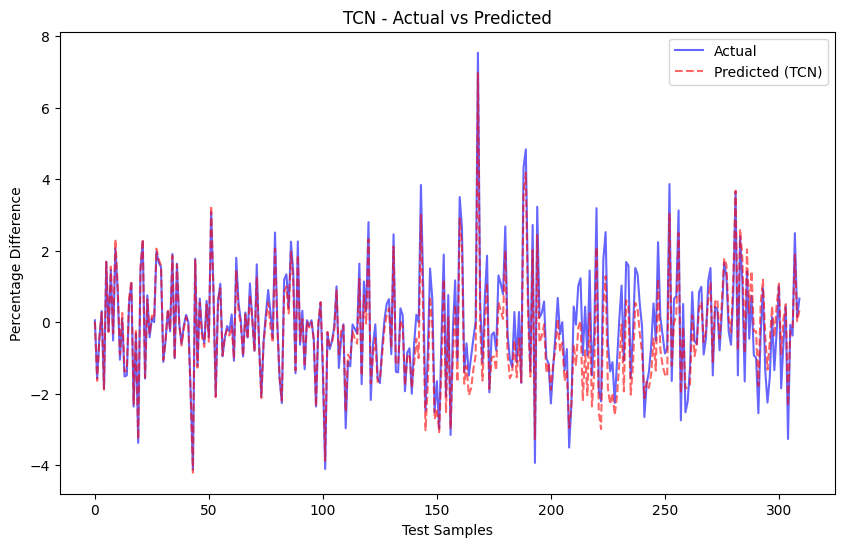

In [88]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Input for TCN
inputs = Input(shape=(X_train.shape[1], 1))

# TCN Layers
x = Conv1D(filters=64, kernel_size=2, padding='causal', activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)

# Output Layer
outputs = Dense(1)(x)

# Model
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate
loss = model.evaluate(X_test, y_test)
print(f'TCN Model Loss: {loss}')

# Predict on test data
y_pred_tcn = model.predict(X_test)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='b', alpha=0.6)
plt.plot(y_pred_tcn, label='Predicted (TCN)', color='r', alpha=0.6, linestyle='--')
plt.title('TCN - Actual vs Predicted')
plt.xlabel('Test Samples')
plt.ylabel('Percentage Difference')
plt.legend()
plt.show()


Hybrid Model: LSTM + XGBoost

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.7863 - val_loss: 2.3635
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.7216 - val_loss: 1.6765
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4992 - val_loss: 0.9238
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1155 - val_loss: 0.4098
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5267 - val_loss: 0.1232
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4212 - val_loss: 0.0303
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2983 - val_loss: 0.0183
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0874 - val_loss: 0.0147
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0850 - val_loss: 0.0202
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1325 - val_loss: 0.0063
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1093 - val_loss: 0.0044
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss

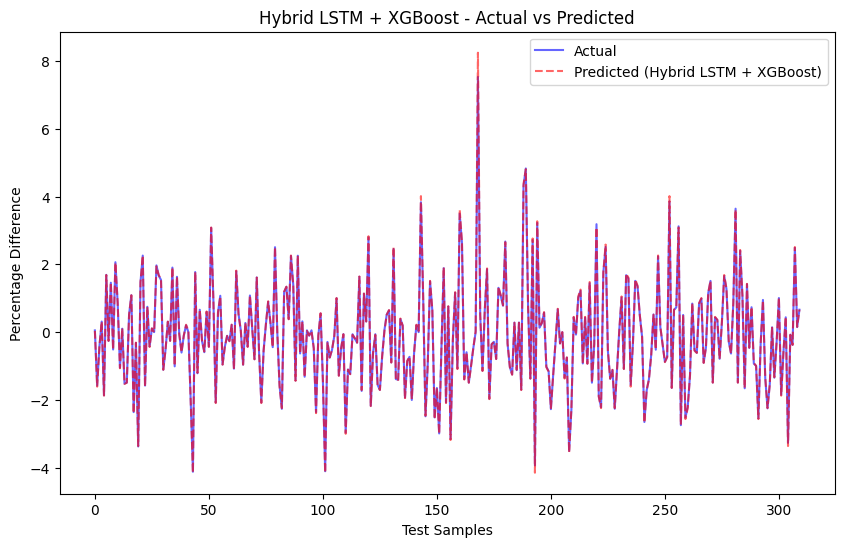

In [91]:
import xgboost as xgb

# Train LSTM model and get features from the second to last layer
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dense(units=1))  # Feature extraction
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Get the extracted features from LSTM
X_train_lstm = lstm_model.predict(X_train)
X_test_lstm = lstm_model.predict(X_test)

# Train XGBoost model on the extracted features
xg_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xg_model.fit(X_train_lstm, y_train)

# Evaluate XGBoost model
preds = xg_model.predict(X_test_lstm)
mse = np.mean((preds - y_test)**2)
print(f'Hybrid LSTM + XGBoost Model MSE: {mse}')

# Predict on test data with XGBoost
y_pred_hybrid = xg_model.predict(X_test_lstm)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='b', alpha=0.6)
plt.plot(y_pred_hybrid, label='Predicted (Hybrid LSTM + XGBoost)', color='r', alpha=0.6, linestyle='--')
plt.title('Hybrid LSTM + XGBoost - Actual vs Predicted')
plt.xlabel('Test Samples')
plt.ylabel('Percentage Difference')
plt.legend()
plt.show()


# Evaluate the Model's Financial Performance

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_trading_strategy(y_test, y_pred, initial_capital=10000, fixed_position_size=100, 
                              buy_thresholds=np.arange(0.1, 3, 0.1), sell_thresholds=np.arange(-3, -0.1, 0.1)):
    """
    Evaluate a trading strategy based on model predictions and varying buy/sell thresholds.

    Parameters:
    - y_test (array-like): Actual percentage changes in closing price.
    - y_pred (array-like): Predicted percentage changes in closing price.
    - initial_capital (float): Initial amount of capital for trading.
    - fixed_position_size (float): Fixed dollar amount to invest in each trade.
    - buy_thresholds (array-like): Range of buy thresholds to test (in percentage).
    - sell_thresholds (array-like): Range of sell thresholds to test (in percentage).

    Returns:
    - best_result (tuple): The best threshold combination and corresponding total return.
    - results_df (DataFrame): DataFrame containing all tested threshold combinations and their returns.
    """

    # Convert percentage changes to actual price change factors
    y_test_factors = (1 + y_test / 100)  # Convert to factor changes
    y_pred = y_pred.flatten()  # Ensure predictions are a flat array

    # Store results
    results = []

    # Simulate the trading strategy for each combination of thresholds
    for buy_threshold in buy_thresholds:
        for sell_threshold in sell_thresholds:
            capital = initial_capital
            position_value = 0  # Value of the current position in dollars
            capital_over_time = []

            for actual_factor, predicted_change in zip(y_test_factors, y_pred):
                if predicted_change > buy_threshold and capital >= fixed_position_size:
                    # Buy - Invest a fixed amount
                    capital -= fixed_position_size
                    position_value += fixed_position_size  # Add to position value
                elif predicted_change < sell_threshold and position_value > 0:
                    # Sell - Realize profit or loss
                    capital += position_value * actual_factor
                    position_value = 0  # Clear position

                # Update capital over time
                current_value = capital + (position_value * actual_factor if position_value > 0 else 0)
                capital_over_time.append(current_value)

            # Calculate total return for this combination of thresholds
            total_return = (capital_over_time[-1] - initial_capital) / initial_capital * 100
            results.append((buy_threshold, sell_threshold, total_return))

    # Convert results to DataFrame for easy analysis
    results_df = pd.DataFrame(results, columns=['Buy Threshold', 'Sell Threshold', 'Total Return'])

    # Find the best threshold combination
    best_result = results_df.loc[results_df['Total Return'].idxmax()]
    print(f"Best Buy Threshold: {best_result['Buy Threshold']}, Best Sell Threshold: {best_result['Sell Threshold']}, Total Return: {best_result['Total Return']:.2f}%")

    # Plot the results
    plt.figure(figsize=(12, 8))
    for sell_threshold in sell_thresholds:
        subset = results_df[results_df['Sell Threshold'] == sell_threshold]
        plt.plot(subset['Buy Threshold'], subset['Total Return'], label=f'Sell Threshold {sell_threshold:.2f}')

    plt.title('Total Return for Different Threshold Combinations')
    plt.xlabel('Buy Threshold (%)')
    plt.ylabel('Total Return (%)')
    plt.legend(title='Sell Threshold')
    plt.show()

    return best_result, results_df


Best Buy Threshold: 2.8000000000000003, Best Sell Threshold: -1.0999999999999983, Total Return: -0.19%


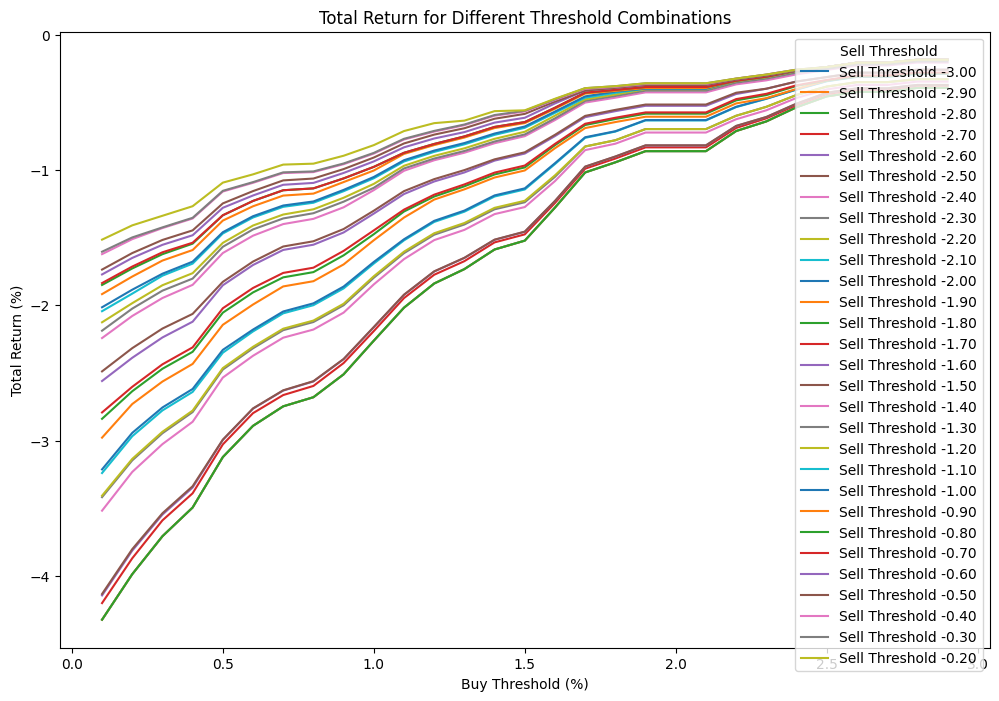

In [136]:
# Example usage:
best_result, results_df = evaluate_trading_strategy(y_test, y_pred_transformer)

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_and_plot_best_strategy_on_prices(close_prices, y_test, y_pred, initial_capital=10000, fixed_position_size=100, 
                                              buy_thresholds=np.arange(0.1, 3, 0.1), 
                                              sell_thresholds=np.arange(-2, -0.1, 0.2),
                                              stop_loss=0.05, take_profit=0.05):
    """
    Evaluate a trading strategy based on model predictions and varying buy/sell thresholds,
    and plot the buy/sell signals on the closing price data along with profit over time.

    Parameters:
    - close_prices (array-like): Actual closing prices.
    - y_test (array-like): Actual percentage changes in closing price.
    - y_pred (array-like): Predicted percentage changes in closing price.
    - initial_capital (float): Initial amount of capital for trading.
    - fixed_position_size (float): Fixed dollar amount to invest in each trade.
    - buy_thresholds (array-like): Range of buy thresholds to test (in percentage).
    - sell_thresholds (array-like): Range of sell thresholds to test (in percentage).

    Returns:
    - best_result (tuple): The best threshold combination and corresponding total return.
    - results_df (DataFrame): DataFrame containing all tested threshold combinations and their returns.
    """

    # Convert percentage changes to actual price change factors
    y_test_factors = (1 + y_test / 100)  # Convert to factor changes
    y_pred = y_pred.flatten()  # Ensure predictions are a flat array

    # Store results
    results = []

    # Simulate the trading strategy for each combination of thresholds
    for buy_threshold in buy_thresholds:
        for sell_threshold in sell_thresholds:
            capital = initial_capital
            position_value = 0  # Value of the current position in dollars
            capital_over_time = []
            buy_signals = []
            sell_signals = []
            profits_over_time = []  # To track profit over time
            trade_details = []  # To track buy/sell prices and dates

            for i, (actual_factor, predicted_change) in enumerate(zip(y_test_factors, y_pred)):
                if predicted_change > buy_threshold and capital >= fixed_position_size:
                    # Buy - Invest a fixed amount
                    capital -= fixed_position_size
                    position_value += fixed_position_size  # Add to position value
                    buy_signals.append(i)  # Record buy index
                    buy_price = close_prices[i]  # Record buy price
                    trade_details.append(('Buy', i, buy_price, None))  # Store trade detail
                elif predicted_change < sell_threshold and position_value > 0:
                    # Check stop-loss or take-profit conditions
                    current_price = close_prices[i]
                    if current_price <= buy_price * (1 - stop_loss) or current_price >= buy_price * (1 + take_profit):
                        # Sell - Realize profit or loss based on stop-loss or take-profit
                        sell_signals.append(i)  # Record sell index
                        sell_price = current_price  # Record sell price
                        capital += (sell_price / buy_price) * position_value  # Update capital
                        position_value = 0  # Clear position
                        trade_details[-1] = ('Buy', trade_details[-1][1], trade_details[-1][2], sell_price)  # Update trade detail with sell price

                # Update capital over time
                current_value = capital + (position_value * actual_factor if position_value > 0 else 0)
                capital_over_time.append(current_value)

                # Calculate profit as the difference between current and initial capital
                profit = current_value - initial_capital
                profits_over_time.append(profit)

            # Calculate total return for this combination of thresholds
            total_return = (capital_over_time[-1] - initial_capital) / initial_capital * 100
            results.append((buy_threshold, sell_threshold, total_return, buy_signals, sell_signals, profits_over_time, trade_details))

    # Convert results to DataFrame for easy analysis
    results_df = pd.DataFrame(results, columns=['Buy Threshold', 'Sell Threshold', 'Total Return', 'Buy Signals', 'Sell Signals', 'Profits Over Time', 'Trade Details'])

    # Find the best threshold combination
    best_result = results_df.loc[results_df['Total Return'].idxmax()]
    best_buy_threshold = best_result['Buy Threshold']
    best_sell_threshold = best_result['Sell Threshold']
    best_buy_signals = best_result['Buy Signals']
    best_sell_signals = best_result['Sell Signals']
    best_profits_over_time = best_result['Profits Over Time']
    best_trade_details = best_result['Trade Details']

    print(f"Best Buy Threshold: {best_buy_threshold}, Best Sell Threshold: {best_sell_threshold}, Total Return: {best_result['Total Return']:.2f}%")
    print("\nTrade Details (Buy/Sell Prices):")
    for action, idx, buy_price, sell_price in best_trade_details:
        if action == 'Buy' and sell_price is not None:
            print(f"Bought at index {idx} for {buy_price:.2f}$, Sold at index {idx} for {sell_price:.2f}$")
        elif action == 'Buy':
            print(f"Bought at index {idx} for ${buy_price:.2f}, not yet sold.")

    # Plot actual closing prices with buy/sell markers for the best threshold combination
    plt.figure(figsize=(14, 8))
    
    # Plot closing prices and buy/sell signals
    plt.subplot(2, 1, 1)
    plt.plot(close_prices, label='Closing Prices', color='b', alpha=0.6)
    plt.scatter(best_buy_signals, close_prices[best_buy_signals], color='g', marker='^', label='Buy Signal', s=100)
    plt.scatter(best_sell_signals, close_prices[best_sell_signals], color='r', marker='v', label='Sell Signal', s=100)
    plt.title(f'Best Buy/Sell Signals on Closing Prices with Buy Threshold: {best_buy_threshold:.2f}, Sell Threshold: {best_sell_threshold:.2f}')
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.legend()

    # Plot profits over time
    plt.subplot(2, 1, 2)
    plt.plot(best_profits_over_time, label='Profit Over Time', color='orange')
    plt.title('Profit Over Time')
    plt.xlabel('Time')
    plt.ylabel('Profit ($)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return best_result, results_df


Best Buy Threshold: 2.9000000000000004, Best Sell Threshold: -2.0, Total Return: -0.56%

Trade Details (Buy/Sell Prices):
Bought at index 51 for 19.07$, Sold at index 51 for 17.70$
Bought at index 143 for 14.35$, Sold at index 143 for 13.30$
Bought at index 160 for $13.32, not yet sold.
Bought at index 168 for $13.99, not yet sold.
Bought at index 188 for $14.49, not yet sold.
Bought at index 189 for $15.19, not yet sold.
Bought at index 194 for 15.37$, Sold at index 194 for 14.03$
Bought at index 252 for $13.99, not yet sold.
Bought at index 281 for $14.79, not yet sold.
Bought at index 283 for $14.92, not yet sold.


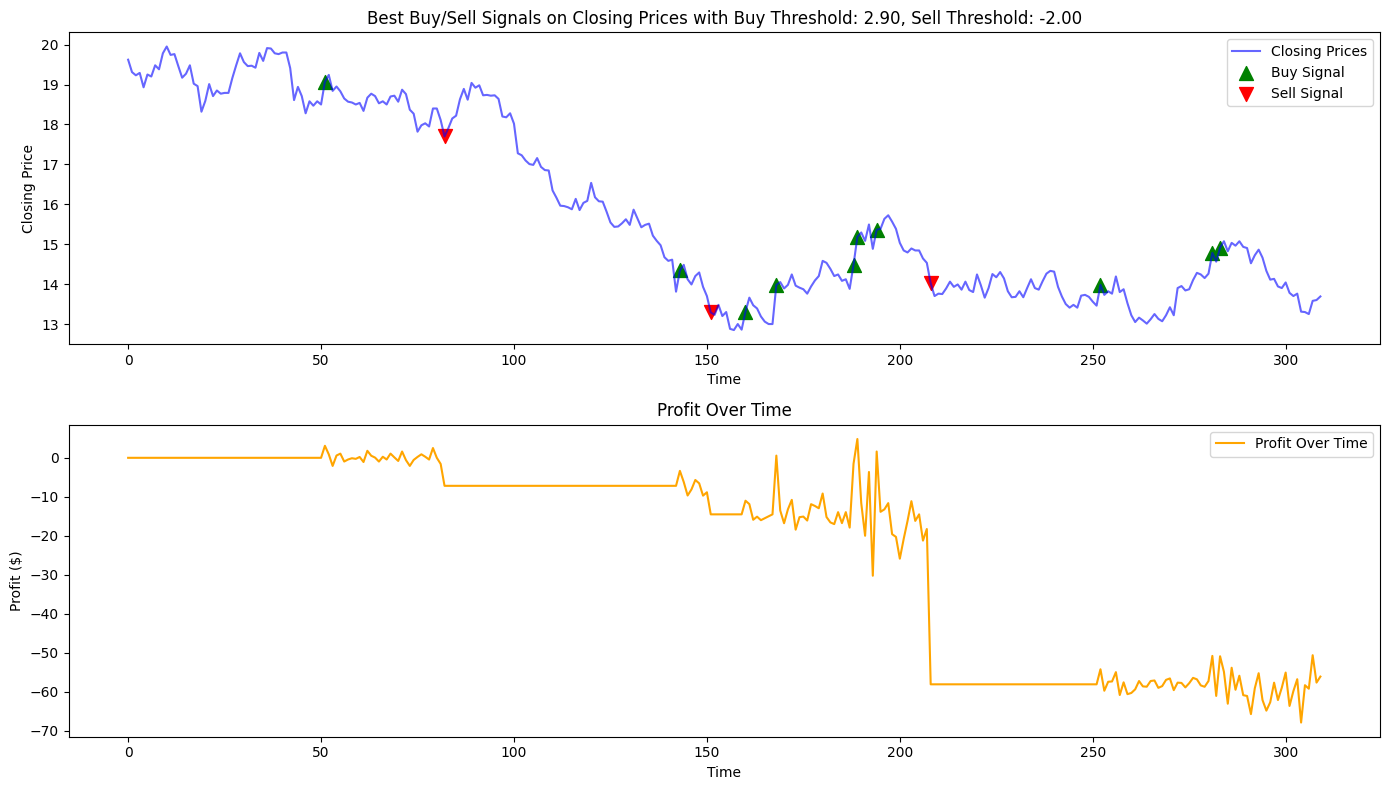

In [86]:
close_prices = df.iloc[split_index:]['Close'].to_numpy()
best_result, results_df = evaluate_and_plot_best_strategy_on_prices(close_prices, y_test, y_pred_fnn)

Best Buy Threshold: 3.2, Total Return: 0.09%

Trade Details (Buy/Sell Prices):
Bought at index 51 for $19.07, Sold the next day for $19.24
Bought at index 143 for $14.35, Sold the next day for $14.49
Bought at index 160 for $13.32, Sold the next day for $13.67
Bought at index 168 for $13.99, Sold the next day for $14.06
Bought at index 188 for $14.49, Sold the next day for $15.19
Bought at index 189 for $15.19, Sold the next day for $15.30
Bought at index 281 for $14.79, Sold the next day for $14.57


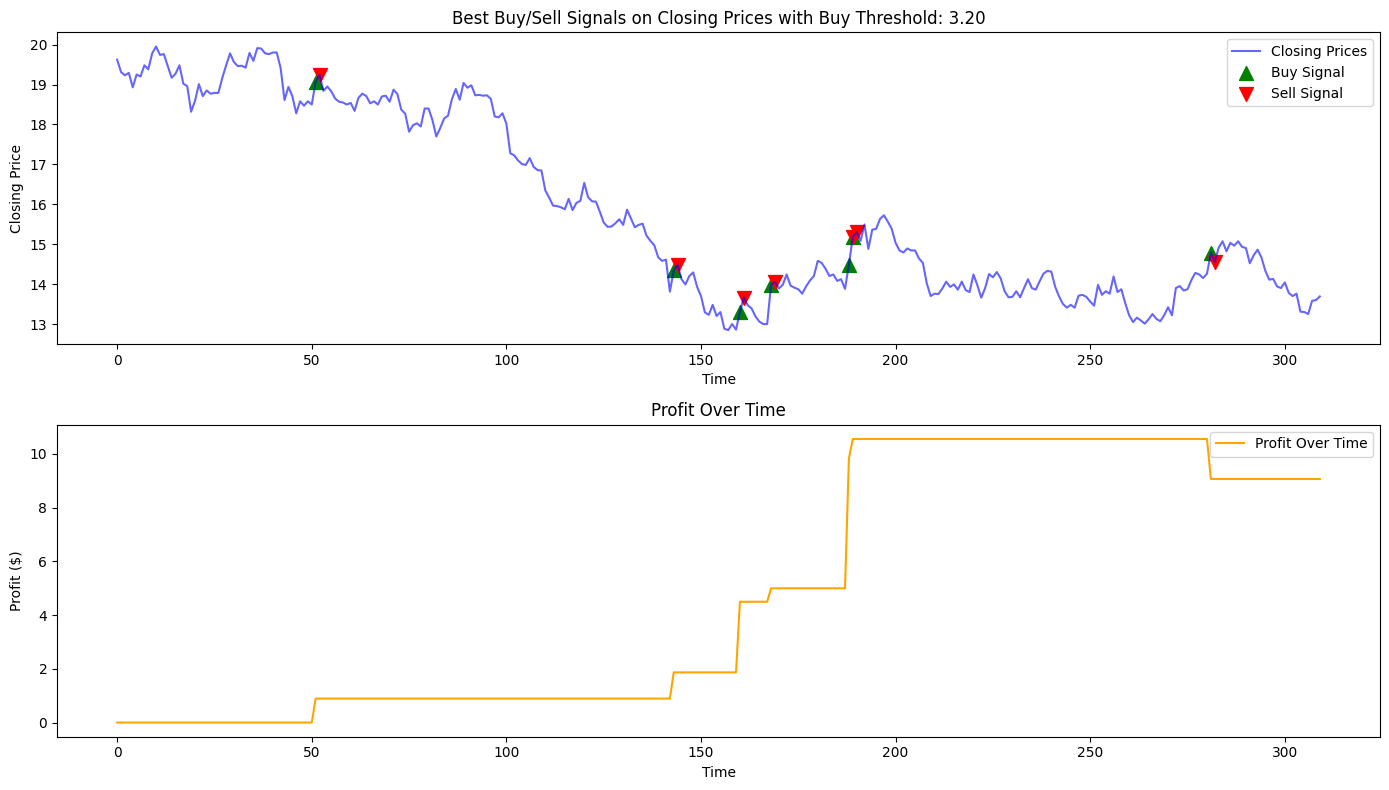

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_and_plot_best_strategy_next_day_sale(close_prices, y_test, y_pred, initial_capital=10000, fixed_position_size=100, 
                                                  buy_thresholds=np.arange(0, 10, 0.1)):
    """
    Evaluate a trading strategy where each stock is sold one day after buying, 
    and plot the buy/sell signals on the closing price data along with profit over time.

    Parameters:
    - close_prices (array-like): Actual closing prices.
    - y_test (array-like): Actual percentage changes in closing price.
    - y_pred (array-like): Predicted percentage changes in closing price.
    - initial_capital (float): Initial amount of capital for trading.
    - fixed_position_size (float): Fixed dollar amount to invest in each trade.
    - buy_thresholds (array-like): Range of buy thresholds to test (in percentage).
    - sell_thresholds (array-like): Range of sell thresholds to test (in percentage).

    Returns:
    - best_result (tuple): The best threshold combination and corresponding total return.
    - results_df (DataFrame): DataFrame containing all tested threshold combinations and their returns.
    """

    # Convert percentage changes to actual price change factors
    y_test_factors = (1 + y_test / 100)  # Convert to factor changes
    y_pred = y_pred.flatten()  # Ensure predictions are a flat array

    # Store results
    results = []

    # Simulate the trading strategy for each combination of thresholds
    for buy_threshold in buy_thresholds:
        capital = initial_capital
        position_value = 0  # Value of the current position in dollars
        capital_over_time = []
        buy_signals = []
        sell_signals = []
        profits_over_time = []  # To track profit over time
        trade_details = []  # To track buy/sell prices and dates

        for i, (actual_factor, predicted_change) in enumerate(zip(y_test_factors, y_pred)):
            if predicted_change > buy_threshold and capital >= fixed_position_size:
                # Buy - Invest a fixed amount
                capital -= fixed_position_size
                position_value += fixed_position_size  # Add to position value
                buy_signals.append(i)  # Record buy index
                buy_price = close_prices[i]  # Record buy price
                trade_details.append(('Buy', i, buy_price, None))  # Store trade detail

                # Sell the next day (if possible)
                if i + 1 < len(close_prices):
                    sell_price = close_prices[i + 1]  # Next day's closing price
                    capital += (sell_price / buy_price) * position_value  # Update capital based on the return
                    position_value = 0  # Clear position
                    sell_signals.append(i + 1)  # Record sell index
                    trade_details[-1] = ('Buy', trade_details[-1][1], trade_details[-1][2], sell_price)  # Update trade detail with sell price

            # Update capital over time
            current_value = capital + (position_value if position_value > 0 else 0)
            capital_over_time.append(current_value)

            # Calculate profit as the difference between current and initial capital
            profit = current_value - initial_capital
            profits_over_time.append(profit)

        # Calculate total return for this combination of thresholds
        total_return = (capital_over_time[-1] - initial_capital) / initial_capital * 100
        results.append((buy_threshold, total_return, buy_signals, sell_signals, profits_over_time, trade_details))

    # Convert results to DataFrame for easy analysis
    results_df = pd.DataFrame(results, columns=['Buy Threshold', 'Total Return', 'Buy Signals', 'Sell Signals', 'Profits Over Time', 'Trade Details'])

    # Find the best threshold combination
    best_result = results_df.loc[results_df['Total Return'].idxmax()]
    best_buy_threshold = best_result['Buy Threshold']
    best_buy_signals = best_result['Buy Signals']
    best_sell_signals = best_result['Sell Signals']
    best_profits_over_time = best_result['Profits Over Time']
    best_trade_details = best_result['Trade Details']

    print(f"Best Buy Threshold: {best_buy_threshold}, Total Return: {best_result['Total Return']:.2f}%")
    print("\nTrade Details (Buy/Sell Prices):")
    for action, idx, buy_price, sell_price in best_trade_details:
        if action == 'Buy' and sell_price is not None:
            print(f"Bought at index {idx} for ${buy_price:.2f}, Sold the next day for ${sell_price:.2f}")
        elif action == 'Buy':
            print(f"Bought at index {idx} for ${buy_price:.2f}, not yet sold.")

    # Plot actual closing prices with buy/sell markers for the best threshold combination
    plt.figure(figsize=(14, 8))
    
    # Plot closing prices and buy/sell signals
    plt.subplot(2, 1, 1)
    plt.plot(close_prices, label='Closing Prices', color='b', alpha=0.6)
    plt.scatter(best_buy_signals, close_prices[best_buy_signals], color='g', marker='^', label='Buy Signal', s=100)
    plt.scatter(best_sell_signals, close_prices[best_sell_signals], color='r', marker='v', label='Sell Signal', s=100)
    plt.title(f'Best Buy/Sell Signals on Closing Prices with Buy Threshold: {best_buy_threshold:.2f}')
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.legend()

    # Plot profits over time
    plt.subplot(2, 1, 2)
    plt.plot(best_profits_over_time, label='Profit Over Time', color='orange')
    plt.title('Profit Over Time')
    plt.xlabel('Time')
    plt.ylabel('Profit ($)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return best_result, results_df

# Example usage with fixed next-day sell strategy:
best_result, results_df = evaluate_and_plot_best_strategy_next_day_sale(close_prices, y_test, y_pred_fnn)
